In [1]:
def drop_trials(epochs, chs=1, do_peak=0, do_mean=0, do_slope=0, T1=0, T2=0):
    """
    This function drops trials from the epochs based on criteria such as peak-to-peak amplitude, mean, or slope
    within a time window (T1, T2). Trials that do not meet these criteria are marked for rejection.
    
    Parameters:
        epochs: MNE Epochs object containing trial data.
        chs: Number of channels to process.
        do_peak: Whether to reject trials based on peak amplitude (1 to enable).
        do_mean: Whether to reject trials based on mean amplitude (1 to enable).
        do_slope: Whether to reject trials based on signal slope (1 to enable).
        T1, T2: Time window for processing the trials.
        
    Returns:
        new_epochs: Updated epochs with dropped trials.
        peak_rejection, mean_rejection, slope_rejection: Counters for rejected trials.
        list_trials: List indicating which trials were kept (1) or rejected (0).
    """
    # Make a copy of the epochs data
    new_epochs = epochs.copy()
    list_trials = np.ones(len(new_epochs))  # Initialize a list to mark good trials

    for j in range(chs):
        peak_rejection, mean_rejection, slope_rejection = 0, 0, 0  # Initialize rejection counters

        # Rejection based on peak amplitude
        if do_peak == 1:
            # Find time indices for the rejection window
            time1 = np.where(new_epochs.times < T1)[0][-1]
            time2 = np.where(new_epochs.times < T2)[0][-1]

            # Compute peak-to-peak values for each trial and channel
            peak_to_peak = np.array([max(new_epochs._data[i][j][time1:time2]) - min(new_epochs._data[i][j][time1:time2]) for i in range(len(new_epochs._data))], dtype=np.dtype(float))
            Q1, Q3 = np.nanquantile(peak_to_peak, [.25, .75])
            outlier_up_peak = Q3 + (2 * iqr(peak_to_peak, nan_policy='omit'))

            idx = [i for i, value in enumerate(peak_to_peak) if value > outlier_up_peak]  # Find outlier trials

            peak_to_peak[idx] = None  # Mark the outliers
            list_trials[idx] = 0  # Mark trials for rejection
            peak_rejection += len(idx)

        # Rejection based on slope
        if do_slope == 1:
            time1 = np.where(new_epochs.times < T1)[0][-1]
            time2 = np.where(new_epochs.times < T2)[0][-1]
            x = new_epochs.times[time1:time2]

            # Calculate slope for each trial
            slopes_trials = np.array([np.polyfit(x, new_epochs._data[i, j, time1:time2], 1)[0] for i in range(len(new_epochs._data))], dtype=np.dtype(float))

            Q1, Q3 = np.nanquantile(slopes_trials, [.25, .75])
            outlier_up_mean = Q1 + (2 * iqr(slopes_trials, nan_policy='omit'))
            outlier_down_mean = Q3 - (2 * iqr(slopes_trials, nan_policy='omit'))

            idx = [i for i, value in enumerate(slopes_trials) if value > outlier_up_mean or value < outlier_down_mean]

            slopes_trials[idx] = None
            list_trials[idx] = 0  # Mark trials for rejection
            slope_rejection += len(idx)

        # Rejection based on mean amplitude
        if do_mean == 1:
            time1 = np.where(new_epochs.times < T1)[0][-1]
            time2 = np.where(new_epochs.times < T2)[0][-1]
            mean_trials = np.array([np.mean(new_epochs._data[i][j][time1:time2]) for i in range(len(new_epochs._data))], dtype=np.dtype(float))

            Q1, Q3 = np.nanquantile(mean_trials, [.25, .75])
            outlier_up_mean = Q3 + (2 * iqr(mean_trials, nan_policy='omit'))
            outlier_down_mean = Q1 - (2 * iqr(mean_trials, nan_policy='omit'))

            idx = [i for i, value in enumerate(mean_trials) if value > outlier_up_mean or value < outlier_down_mean]

            mean_trials[idx] = None
            list_trials[idx] = 0  # Mark trials for rejection
            mean_rejection += len(idx)

    # Drop the rejected trials and return the updated epochs
    new_epochs.drop(np.where(list_trials == 0)[0])
    return new_epochs, peak_rejection, mean_rejection, slope_rejection, list_trials


In [2]:
import os, re, mne, csv
import numpy as np
from mne.channels import make_standard_montage
from glob import glob
from scipy import stats
from scipy.stats import iqr

# Set working directory to where the EEG data files are located
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Eva_Freedom/derivatives')

# Load the list of raw EEG data files
data_files = glob('*_raw.fif')


In [6]:
drop_rp = []  # To track dropped trials
RTs = []  # To track reaction times

# Loop over participants
for i, part in enumerate(data_files):
    n_part = part.split("sub-")[1].split("\\")[0]  # Extract participant ID
    raw = mne.io.read_raw_fif(part, preload=True)  # Load the raw EEG data
    
    if i == 0:  # Create a forward model for EEG referencing
        sphere = mne.make_sphere_model('auto', 'auto', raw.info)
        src = mne.setup_volume_source_space(sphere=sphere)
        forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
    
    raw.set_eeg_reference('REST', forward=forward)  # Set REST reference using forward model

    # Find events and define event types related to actions
    events = mne.find_events(raw, shortest_event=1)
    event_action = { 'action/free': 17, 'action/recommended': 18, 'action/semi-instructed': 19, 'action/instructed': 20 }

    # Create epochs for the events
    epochs = mne.Epochs(raw, events, baseline=None, event_id=event_action, picks="Cz", 
                        tmin=-3, tmax=3, preload=True, detrend=None, on_missing='ignore')
    
    epochs.apply_baseline((-.005, .005))  # Apply baseline correction

    # Call the drop_trials function to remove bad trials
    _, _, _, _, list_ti = drop_trials(epochs, do_mean=1, do_peak=1, do_slope=-1, T1=-2, T2=0, chs=len(epochs.ch_names))

    # Re-create epochs without channel selection to include all channels if topoplot needed for instance
    epochs = mne.Epochs(raw, events, baseline=None, event_id=event_action,
                        tmin=-3, tmax=3, preload=True, detrend=None, on_missing='ignore')
    
    epochs.drop(np.where(list_ti == 0)[0])  # Drop the bad trials based on previous rejection 
    drop_rp.append(epochs.drop_log_stats())
    epochs.save(part.split('raw')[0]+'RP_clean_epo.fif', overwrite=True)



In [1]:
%%capture
import os, mne, csv
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_eva_freedom/derivatives/')
RP_files = glob('*RP_clean_epo.fif')
RP_all = [mne.read_epochs(x).pick("Cz").apply_baseline((-.005,.005)).crop(-2.5,.5)  for x in RP_files]
bad_prt = [1, 10, 19,20]

In [4]:
# Perform grand averaging across participants and plot the averaged ERP data
gr_RP_all = mne.grand_average([part.average() for i,part in enumerate(RP_all) if i not in bad_prt])


Identifying common channels ...


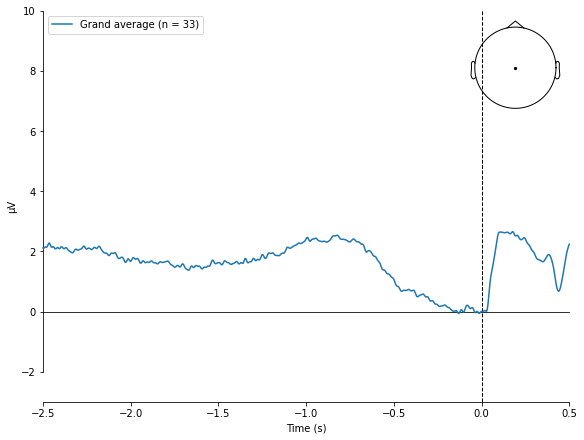

[<Figure size 576x432 with 2 Axes>]

In [5]:
%matplotlib inline
# Plot the grand average ERP with specified y-axis limits

mne.viz.plot_compare_evokeds(gr_RP_all, ylim=dict(eeg=[-3, 10]))

In [6]:
%%capture
# Define the conditions to analyze
conditions = ["instructed", "semi-instructed", "recommended", "free"]
# Initialize a dictionary to store evoked responses for each condition
evokeds_RP_all = {}

# Loop over each condition
for c in conditions:
    # Collect the average evoked responses for each participant, excluding bad participants
    evokeds_RP_all[c] = [
        part[c].average().crop(-2.5, .1)
        for i, part in enumerate(RP_all)
        if i not in bad_prt and len(part[c]) > 0
    ]



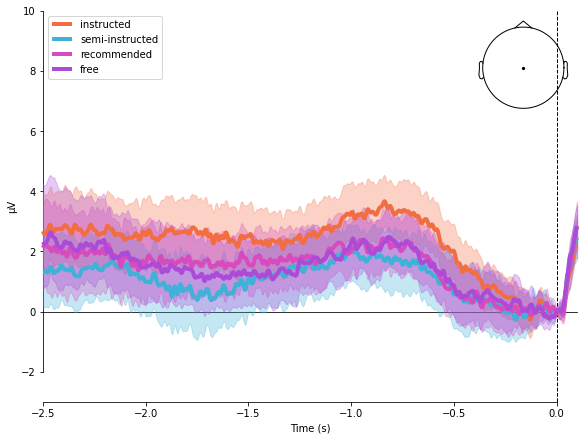

[<Figure size 576x432 with 2 Axes>]

In [7]:
%matplotlib inline
# Plot the grand averages for each condition with specified styles and colors

mne.viz.plot_compare_evokeds(evokeds_RP_all, ylim=dict(eeg=[-3, 10]),
                            linestyles=['solid', 'solid', 'solid', 'solid'],  # Line styles for each grand average
                             styles={'instructed': {"linewidth": 4},  # Style settings for the first grand average
                                     'semi-instructed': {"linewidth": 4},  # Style settings for the second grand average
                                     'recommended': {"linewidth": 4},  # Style settings for the third grand average
                                     'free': {"linewidth": 4},  # Style settings for the third grand average
                                     },
                             
                             colors=["#f26d41","#40b2d8", "#D84BBE", "#ac4bd8"])

In [ ]:

# Open a CSV file to write the extracted data
datafile = open("data_RP_lmer.csv", "w", newline="")
writer = csv.writer(datafile, delimiter=";")
# Write the header row to the CSV file
writer.writerow(["Participant", "conditions", "Trial", "outlier_RP", "mean_RP", "slope_RP"])

# Loop over each participant's data file
for i, part in enumerate(all_files_path):
    # Extract the participant number from the file path
    n_part = part.split("sub-")[1].split("_")[0]
    # Read the raw EEG data for the participant
    raw = mne.io.read_raw_fif(part, preload=True)

    if i == 0:
        # For the first participant, create a spherical head model and compute the forward solution
        sphere = mne.make_sphere_model('auto', 'auto', raw.info)
        src = mne.setup_volume_source_space(sphere=sphere)
        forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
    # Set the EEG reference to REST
    raw.set_eeg_reference('REST', forward=forward)

    # Find events in the raw data
    events = mne.find_events(raw, shortest_event=1)

    # Define the event IDs for different action conditions
    event_action = {
        'action/free': 17,
        'action/recommended': 18,
        'action/semi-instructed': 19,
        'action/instructed': 20
    }

    # Create epochs around the action events, selecting only the 'Cz' channel
    epochs = mne.Epochs(
        raw, events, baseline=None, event_id=event_action, picks="Cz",
        tmin=-3, tmax=3, preload=True, detrend=None, on_missing='ignore'
    )

    # Apply baseline correction
    epochs.apply_baseline((-.005, .005))

    # Use the custom drop_trials function to identify outlier trials
    _, _, _, _, list_ti, _ = drop_trials(
        epochs, do_mean=1, do_peak=1, do_slope=1, T1=-2, T2=0,
        chs=np.arange(len(epochs.ch_names))
    )

    # Define the time window for calculating readiness potentials (-1s to 0s)
    time1_RP = np.where(epochs.times < -1)[0][-1]
    time2_RP = np.where(epochs.times < 0)[0][-1]
    x = epochs.times[time1_RP:time2_RP]
    # Convert data from volts to microvolts for better interpretability
    epochs._data *= 1e6

    # Loop over each trial in the epochs
    for ite_trial in range(len(epochs)):
        # Calculate the mean readiness potential for the trial
        RP_mean = np.mean(epochs._data[ite_trial, 0, time1_RP:time2_RP])
        # Calculate the slope of the readiness potential for the trial
        RP_slope = np.polyfit(x, epochs._data[ite_trial, 0, time1_RP:time2_RP], 1)[0]

        # Determine the condition label for the current trial
        condition = next(
            key for key, value in event_action.items()
            if value == epochs.events[ite_trial, 2]
        ).split("/")[1]

        # Write the extracted data to the CSV file
        writer.writerow([
            n_part, condition, ite_trial, list_ti[ite_trial],
            round(RP_mean, 3), round(RP_slope, 3)
        ])

# Close the CSV file
datafile.close()
